In [1]:
# Specify CUDA device
import os, pickle, time
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax, optax, jaxopt
jax.config.update("jax_enable_x64", True)

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import jax.numpy as jnp
import numpy as np 
from matplotlib import pyplot as plt 

import s2scat 
import s2fft
import s2wav
from s2fft.sampling import s2_samples as samples

gpu


In [2]:
L = 512
N = 3
J_min = 0
reality = True
recursive = False

generator = s2scat.operators.matrices.generate_recursive_matrices if recursive  else s2scat.operators.matrices.generate_precompute_matrices
cmap="magma"

map_type = 'weak_lensing'
f = np.load('texture_maps/{}/CosmoML_f_{}.npy'.format(map_type, L))
flm = np.load('texture_maps/{}/CosmoML_flm_{}.npy'.format(map_type, L))

file = 'texture_maps/{}/targets_{}.pickle'.format(map_type, L)
with open(file, 'rb') as handle:
    targets, norm = pickle.load(handle)

In [3]:
wavelets = s2wav.filters.filters_directional_vectorised(L, N)[0]
matrices = generator(L, N, J_min, reality)
quads = s2scat.operators.spherical.quadrature(L, J_min)
wavelets_linear = s2wav.filters.filters_directional_vectorised(L=L, N=N, J_min=J_min, lam=np.sqrt(2.5))[0][J_min:-2, :, L-1]

In [4]:
# L_in = 512
# L_out = 512

# f_new = s2scat.utility.statistics.normalize_map(f)

# flm = s2fft.forward(f_new, L_in, reality=reality, method="jax")
# flm = samples.flm_2d_to_1d(flm, L_in)
# flm_new = flm[:L_out**2]
# flm_new = samples.flm_1d_to_2d(flm_new, L_out)
# flm_new = s2scat.operators.spherical.make_flm_real(flm, L_out)

# np.save('texture_maps/{}/CosmoML_f_{}.npy'.format(map_type, L_out), f_new)
# np.save('texture_maps/{}/CosmoML_flm_{}.npy'.format(map_type, L_out), flm_new)

# norm = s2scat.utility.normalisation.compute_norm(flm, L, N, J_min, reality, wavelets, matrices, recursive)
# targets = s2scat.core.scatter.directional(flm, L, N, J_min, reality, wavelets, norm, quads, matrices, recursive)

# file = 'texture_maps/{}/targets_{}.pickle'.format(map_type, L)
# with open(file, 'wb') as handle:
#     pickle.dump([targets, norm], handle)


In [5]:
@jax.jit
def get_P00prime(alm, filter_lin, normalisation):
    P00prime_ell = jnp.sum(jnp.abs(alm[None, :, :] * filter_lin[:, :, None])**2, axis=2)  # [Nfilters, L]
    P00prime = jnp.mean(P00prime_ell, axis=1)  # [Nfilters]
    if normalisation is not None:
        P00prime /= normalisation
    return P00prime_ell, P00prime

_, tP00prime_norm = get_P00prime(flm, wavelets_linear, None)
_, tP00prime = get_P00prime(flm, wavelets_linear, tP00prime_norm)

In [6]:
@jax.jit 
def chi2_loss(predicts):
    loss = 0
    for i in range(6):
        loss += jnp.mean(jnp.abs(predicts[i]-targets[i])**2)
    return loss

def loss_func(glm_float):
    # Make complex flm
    # glm = glm_float[0, :, :] + 1j * glm_float[1, :, :]
    glm = glm_float
    predicts = s2scat.core.scatter.directional(glm, L, N, J_min, reality, wavelets, norm, quads, matrices, recursive)
    
    # Match statistics
    loss = chi2_loss(predicts)
    _, P00prime_new = get_P00prime(glm, wavelets_linear, tP00prime_norm)
    loss += jnp.mean(jnp.abs(P00prime_new-tP00prime)**2)

    return loss

In [7]:
def compute_ps(alm):
    """Compute the angular power spectrum Cls = 1/(2l+1) Sum_m[|f_lm|^2]."""
    L = alm.shape[0]
    ell = np.arange(L)
    Cls = jnp.nansum(jnp.abs(alm) ** 2, axis=-1) / (2 * ell + 1)
    # Cls = 2. * Cls - Cls[0]
    return Cls

# def generate_grf(ps, L):
#     alm = np.zeros((L, L), dtype=np.complex128)
#     for l in range(L):
#         alm[l,0] = np.sqrt(ps[l]) * np.random.randn()
#         for m in range(1,l):
#             alm[l,m] = np.sqrt(ps[l]) * (np.random.randn() + 1j*np.random.randn())
#     return alm

In [8]:
# target_ps = compute_ps(flm)
# glm = generate_grf(target_ps, L)
concat = np.concatenate((np.real(flm), np.imag(flm)))
sigma_bar = np.std(concat[concat!=0])
print(sigma_bar)
glm = np.random.randn(L, L) * sigma_bar + 1j*np.random.randn(L, L) * sigma_bar 
glm_start = jnp.copy(glm)
g_start = s2fft.inverse(s2scat.operators.spherical.make_flm_full(glm_start, L), L, reality=reality, method="jax")

0.004889319775086215


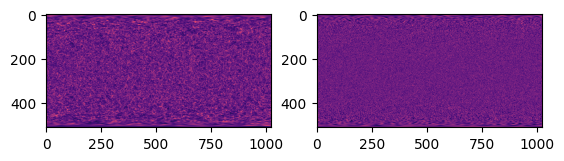

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2)
mx, mn = np.nanmax(f), np.nanmin(f)
ax1.imshow(f, cmap=cmap, vmax=mx, vmin=mn)
ax2.imshow(g_start, cmap=cmap, vmax=mx, vmin=mn)
plt.show()

In [10]:
def fit_jaxopt_Scipy(params, loss_func, method='L-BFGS-B', niter: int = 10, loss_history: list = None):
    if loss_history is None:
        loss_history = []
        loss_history.append(loss_func(params))

    optimizer = jaxopt.ScipyMinimize(fun=loss_func, method=method, jit=False, maxiter=1)

    for i in range(niter):
        start = time.time()
        params, opt_state = optimizer.run(params)
        end = time.time()
        if i % 10 == 0:
            loss_history.append(opt_state.fun_val)
            print(
                f'Iter {i}, Success: {opt_state.success}, Loss = {opt_state.fun_val}, Time = {end - start:.5f} s/iter')

    return params, loss_history

def fit_optax(params: optax.Params, optimizer: optax.GradientTransformation, loss_func,
              niter: int = 10, loss_history: list = None) -> optax.Params:
    ### Gradient of the loss function
    grad_func = jax.grad(loss_func)

    if loss_history is None:
        loss_history = []
    opt_state = optimizer.init(params)
    for i in range(niter):
        start = time.time()
        grads = jnp.conj(grad_func(params)) 
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        end = time.time()

        # Save iterant for animation
        filename = '/disk/xray0/mp2/synthesis_iterations/map_{}.npy'.format(i).zfill(4)
        np.save(filename, params)

        if i % 10 == 0:
            loss_value = loss_func(params)
            loss_history.append(loss_value)
            print(f'Iter {i}, Loss: {loss_value:.10f}, Time = {end - start:.5f} s/iter')

    return params, loss_history

In [11]:
### OPTAX
niter = 2000
optimizer = optax.adam(1e-4)
glm, loss_history = fit_optax(glm, optimizer, loss_func, niter=niter, loss_history=None)
glm_end = jnp.copy(glm)

# ### JAXOPT
# niter=200
# glm_float = jnp.array([jnp.real(glm), jnp.imag(glm)]) # [2, L, L]          
# glm, loss_history = fit_jaxopt_Scipy(glm_float, loss_func, method='L-BFGS-B', niter=niter, loss_history=None)
# glm_end = glm[0, :, :] + 1j * glm[1, :, :]

2024-04-19 17:34:15.549611: W external/xla/xla/service/hlo_rematerialization.cc:2946] Can't reduce memory use below 19.20GiB (20621001283 bytes) by rematerialization; only reduced to 19.32GiB (20742464668 bytes), down from 21.53GiB (23119657132 bytes) originally


Iter 0, Loss: 464.9667593322, Time = 20.64208 s/iter
Iter 10, Loss: 267.4077956541, Time = 0.18799 s/iter
Iter 20, Loss: 154.5069694487, Time = 0.19254 s/iter
Iter 30, Loss: 93.3325276057, Time = 0.19296 s/iter
Iter 40, Loss: 60.0460589345, Time = 0.19379 s/iter
Iter 50, Loss: 41.1586454288, Time = 0.19163 s/iter
Iter 60, Loss: 29.7888567976, Time = 0.19287 s/iter
Iter 70, Loss: 22.5112115102, Time = 0.19282 s/iter
Iter 80, Loss: 17.5873081284, Time = 0.23247 s/iter
Iter 90, Loss: 14.0980368264, Time = 0.19262 s/iter
Iter 100, Loss: 11.5320653205, Time = 0.19301 s/iter
Iter 110, Loss: 9.5882212846, Time = 0.19273 s/iter
Iter 120, Loss: 8.0801935081, Time = 0.19011 s/iter
Iter 130, Loss: 6.8873083910, Time = 0.19522 s/iter
Iter 140, Loss: 5.9284196511, Time = 0.19405 s/iter
Iter 150, Loss: 5.1469012667, Time = 0.19262 s/iter
Iter 160, Loss: 4.5023941462, Time = 0.28688 s/iter
Iter 170, Loss: 3.9653310766, Time = 0.19308 s/iter
Iter 180, Loss: 3.5132871013, Time = 0.19017 s/iter
Iter 190

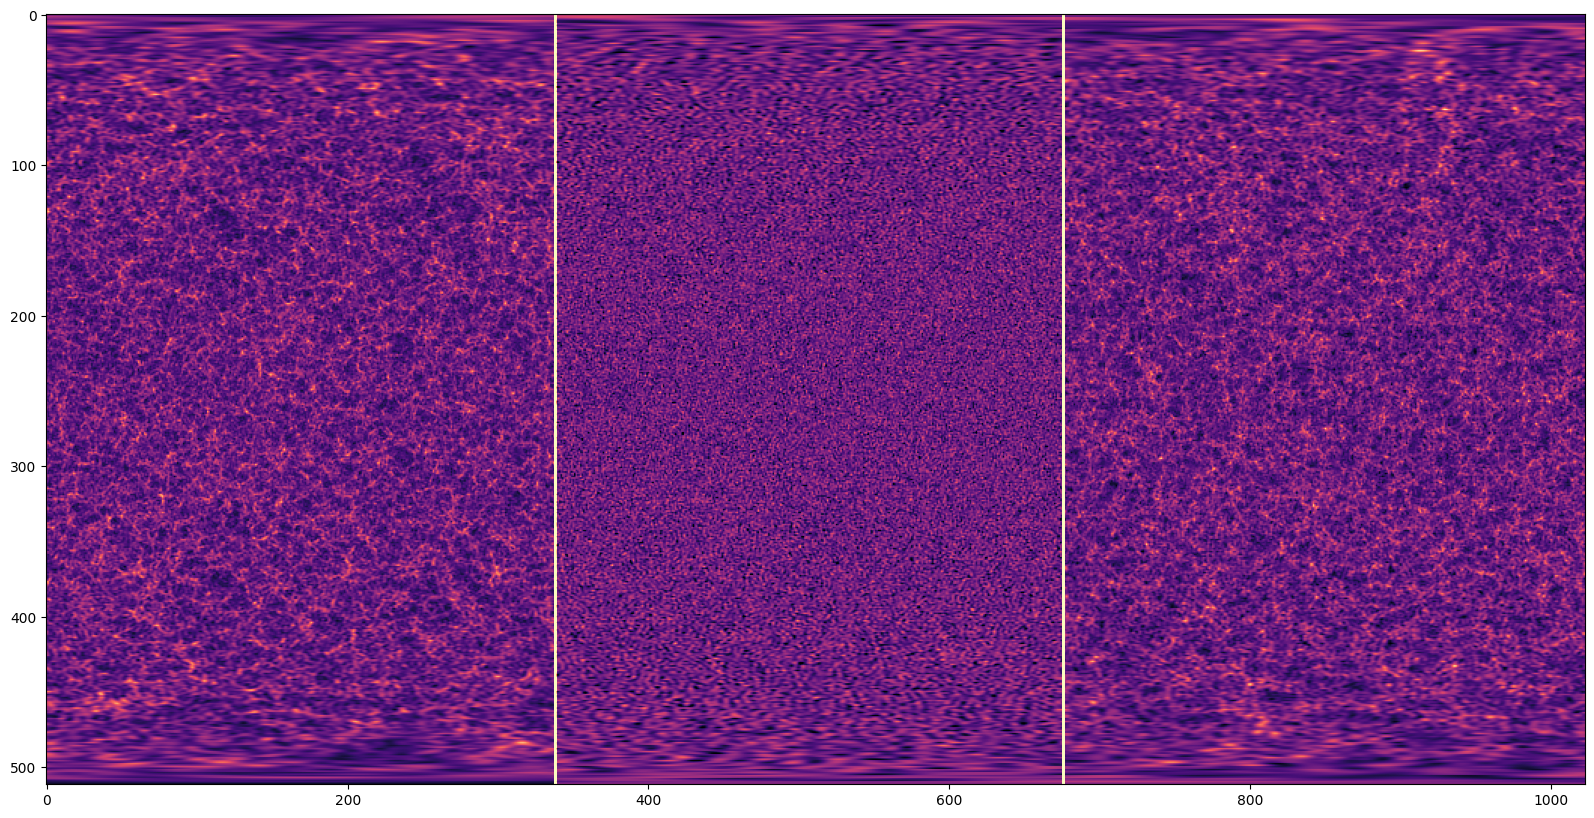

In [13]:
g_end = s2fft.inverse(s2scat.operators.spherical.make_flm_full(glm_end, L), L, reality=reality, method="jax")
temp = np.zeros_like(g_end)
L_step = -3+(2*L-1)//3
temp[:,:L_step] = f[:,:L_step]
temp[:,L_step+1:2*L_step] = g_start[:,L_step+1:2*L_step]
temp[:,2*L_step+1:] = g_end[:,2*L_step+1:]

temp[:,L_step] = 100.0
temp[:,2*L_step] = 100.0
mx, mn = np.nanmax(f), np.nanmin(f)
plt.figure(figsize=(20,10))
plt.imshow(temp, cmap=cmap, vmax=mx, vmin=mn)
plt.show()
